# Create and run a local RAG pipeline from scratch

The goal of this notebook is to build a RAG (Retrieval Augmented Generation) pipeline from scratch and have it run on a local GPU.

Specifically, we'd like to be able to open a PDF file, ask questions (queries) of it and have them answered by a Large Language Model (LLM).

There are frameworks that replicate this kind of workflow, including [LlamaIndex](https://www.llamaindex.ai/) and [LangChain](https://www.langchain.com/), however, the goal of building from scratch is to be able to inspect and customize all the parts.

## What is RAG?

RAG stands for Retrieval Augmented Generation.

It was introduced in the paper [*Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks*](https://arxiv.org/abs/2005.11401).

Each step can be roughly broken down to:

* **Retrieval** - Seeking relevant information from a source given a query. For example, getting relevant passages of Wikipedia text from a database given a question.
* **Augmented** - Using the relevant retrieved information to modify an input to a generative model (e.g. an LLM).
* **Generation** - Generating an output given an input. For example, in the case of an LLM, generating a passage of text given an input prompt.

## Why RAG?

The main goal of RAG is to improve the generation outptus of LLMs.

Two primary improvements can be seen as:
1. **Preventing hallucinations** - LLMs are incredible but they are prone to potential hallucination, as in, generating something that *looks* correct but isn't. RAG pipelines can help LLMs generate more factual outputs by providing them with factual (retrieved) inputs. And even if the generated answer from a RAG pipeline doesn't seem correct, because of retrieval, you also have access to the sources where it came from.
2. **Work with custom data** - Many base LLMs are trained with internet-scale text data. This means they have a great ability to model language, however, they often lack specific knowledge. RAG systems can provide LLMs with domain-specific data such as medical information or company documentation and thus customized their outputs to suit specific use cases.

The authors of the original RAG paper mentioned above outlined these two points in their discussion.

> This work offers several positive societal benefits over previous work: the fact that it is more
strongly grounded in real factual knowledge (in this case Wikipedia) makes it “hallucinate” less
with generations that are more factual, and offers more control and interpretability. RAG could be
employed in a wide variety of scenarios with direct benefit to society, for example by endowing it
with a medical index and asking it open-domain questions on that topic, or by helping people be more
effective at their jobs.

RAG can also be a much quicker solution to implement than fine-tuning an LLM on specific data. 


## 1. Document/text Preprocessing and embedding creation

Ingredients:
1. Pdf document of choice (it can work with any document, i've decided to use pdf for now)
2. Embeddings model of choice


Steps:
1. Import pdf 
2. Process Text for embeddings
3. Embed text chunk with embedding model
4. Save embeddings to file for later use


In [1]:
#### import pdf document
import os
import requests
import pandas as pd

## get pdf document path
pdf_path="human-nutrition-text.pdf"

if not os.path.exists(pdf_path):
    print("[INFO] File Does not Exist Downloading PDF document")
    url="https://pressbooks.oer.hawaii.edu/humannutrition2/open/downloadt?type=pdf"
    filename=pdf_path
    
    ##send get request
    response = requests.get(url)       
    
    ##Check if the request is successfull
    if response.status_code==200:
        with open(filename, 'wb') as file:
            file.write(response.content)
        print("[INFO] PDF document downloaded successfully")
    else:
        print("[ERROR] PDF document download failed")
    
     

In [2]:
import fitz
from tqdm.auto import tqdm
import tiktoken
def text_formatter(text:str)->str:
    text = text.replace('\n', " ").strip()
    text = text.replace("\t", " ")
    text = text.replace("\r", " ")    
    return text

def open_and_read_pdf(pdf_path:str)->list[dict]:
    # Open the PDF
    document = fitz.open(pdf_path)
    # Loop through the pages
    encoding = tiktoken.encoding_for_model("gpt-4")
    pages_and_text = []
    for page_num,page in tqdm(enumerate(document)):
        text=page.get_text()
        text = text_formatter(text)
        pages_and_text.append({
            "page_number":page_num-41,
            "text":text,
            "page_char_count":len(text),
            "page_word_count":len(text.split(" ")),
            "page_sentence_count":text.count(".")+text.count("?")+text.count("!"),
            "page_token_count":len(encoding.encode(text)),        
                               })
    return pages_and_text

pages_and_text = open_and_read_pdf(pdf_path)

0it [00:00, ?it/s]

Let's get sample of the text from the document



In [3]:
import random
random.sample(pages_and_text, 5)


[{'page_number': 155,
  'text': 'Learning Activities  Technology Note: The second edition of the Human  Nutrition Open Educational Resource (OER) textbook  features interactive learning activities.  These activities are  available in the web-based textbook and not available in the  downloadable versions (EPUB, Digital PDF, Print_PDF, or  Open Document).  Learning activities may be used across various mobile  devices, however, for the best user experience it is strongly  recommended that users complete these activities using a  desktop or laptop computer and in Google Chrome.    An interactive or media element has been  excluded from this version of the text. You can  view it online here:  http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=135    Overview of Fluid and Electrolyte Balance  |  155',
  'page_char_count': 774,
  'page_word_count': 128,
  'page_sentence_count': 8,
  'page_token_count': 163},
 {'page_number': 286,
  'text': 'HFCS  • high  fructose  corn syrup  Dry  form: 4 

In [18]:
def print_as_df(pages_and_text:list[dict]):
    """Prints the first 5 rows of the dataframe"""
    
    df = pd.DataFrame(pages_and_text)
    
    return df.head()

def print_stats_df(pages_and_text:list[dict]):
    """Prints the first 5 rows of the dataframe"""
    
    df = pd.DataFrame(pages_and_text)
    
    return df.describe()

def convert_to_csv(pages_and_text:list[dict],csv_path:str)->str:
    """Converts the list of dictionaries to a csv file and returns the path to the csv file"""
    df = pd.DataFrame(pages_and_text)
    df.to_csv(csv_path)
    return csv_path

print_as_df(pages_and_text)



,page_number,text,page_char_count,page_word_count,page_sentence_count,page_token_count,sentences,page_sentence_count_with_spacy
0,-41,Human Nutrition: 2020 Edition,29,4,0,7,[Human Nutrition: 2020 Edition],1
1,-40,,0,1,0,0,[],0
2,-39,Human Nutrition: 2020 Edition UNIVERSITY OF ...,320,54,0,131,[Human Nutrition: 2020 Edition UNIVERSITY OF...,1
3,-38,Human Nutrition: 2020 Edition by University of...,212,32,2,45,[Human Nutrition: 2020 Edition by University o...,1
4,-37,Contents Preface University of Hawai‘i at Mā...,797,147,2,188,[Contents Preface University of Hawai‘i at M...,2


### More text processing
The ideal way of processing text before embedding it is still an active area of resarch.

A simple method which is helpful is to break the text into chunk of sentences.

As in, chunk a page of text into groups of 5,7,10 or more senctences. Those value are arbitrary and we can and we  should experiment with different values to see which one works best.

But we want to follow the workflow of:
    
'Ingest text --> split it into groups or chunks --> embed the group or chunk --> use the embedding'
    
There are a few option for splitting text into sentences:

1. Split into sentences using "." (or similar) as separators

2. Split into sentences with a NLP library like [spaCy](https://spacy.io/) or [nltk](https://www.nltk.org/).


We are gonna use spaCy

**Resource:** See [spaCy install instructions](https://spacy.io/usage).



In [13]:
from spacy.lang.en import English

nlp=English()

"""We should try to find something that is multilingual, not just English. But this is a good start."""

nlp.add_pipe("sentencizer")


for item in tqdm(pages_and_text):
    item["sentences"] = [str(sent) for sent in list(nlp(item["text"]).sents)]
    
    item["page_sentence_count_with_spacy"] = len(item["sentences"])
    
    


  0%|          | 0/1208 [00:00<?, ?it/s]

This is just a base, we will build a fully functional chatbot using this functions and code, the code below is gonna be in the function abovem


In [21]:
num_sentences_chunk_size=10

def split_list(input_list:list,slice_size:int)->list:
    """Splits a list into chunks of the specified size"""
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

for item in tqdm(pages_and_text):
    item["sentences_chunked"] = split_list(item["sentences"],num_sentences_chunk_size)
    item["num_sentence_chunks"] = len(item["sentences_chunked"])
    
    



  0%|          | 0/1208 [00:00<?, ?it/s]

### Splitting each chunk in is own item

We have to embed every single chunk of sentences into its own numerical representation



In [23]:
import re


def clean_datas(pages_and_text:list[dict])->list[dict]:
    pages_and_chunks = []
    encoding = tiktoken.encoding_for_model("gpt-4")
    for item in tqdm(pages_and_text):
        for chunk in item["sentences_chunked"]:
            chunk_dict={}
            chunk_dict["page_number"] = item["page_number"]
            joined_sentence_chunk = " ".join(chunk).replace("\n", " ").replace("\t", " ").replace("\r", " ").replace("  ", " ").strip()
            joined_sentence_chunk=re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk)
            chunk_dict["sentence_chunk"] = joined_sentence_chunk
            
            chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
            chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
            chunk_dict["chunk_token_count"] = len(encoding.encode(joined_sentence_chunk))
            
            pages_and_chunks.append(chunk_dict)
    return pages_and_chunks
        
pages_and_chunks = clean_datas(pages_and_text)
   
   
len(pages_and_chunks)       

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

Why we dont check for low tokenized chunks, just to see if they are worth keeping

In [44]:
min_token_length=15
df = pd.DataFrame(pages_and_chunks)
for row in df[df["chunk_token_count"]<min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 9 | Text: Fat-Soluble Vitamins | 537
Chunk token count: 6 | Text: Iodine | 681
Chunk token count: 11 | Text: The Major Types of Foodborne Illness | 993
Chunk token count: 4 | Text: Introduction | 61
Chunk token count: 3 | Text: 622 | Calcium


In [45]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 119},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 43}]


### Embedding the text chunks

While we can understand words pretty good, our computers cant, so we need to convert the words into numbers. This is called embedding. We will use the sentence transformer library to do this.


> **Note:** Most modern NLP models deal with "tokens" which can be considered as multiple different sizes and combinations of words and characters rather than always whole words or single characters. For example, the string `"hello world!"` gets mapped to the token values `{15339: b'hello', 1917: b' world', 0: b'!'}` using [Byte pair encoding](https://en.wikipedia.org/wiki/Byte_pair_encoding) (or BPE via OpenAI's [`tiktoken`](https://github.com/openai/tiktoken) library). Google has a tokenization library called [SentencePiece](https://github.com/google/sentencepiece).




In [50]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device="cpu")

sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", len(embedding))
    print("")

Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: 768

Sentence: Sentences can be embedded one by one or as a list of strings.
Embedding: 768

Sentence: Embeddings are one of the most powerful concepts in machine learning!
Embedding: 768

Sentence: Learn to use embeddings well and you'll be well on your way to being an AI engineer.
Embedding: 768



In [56]:
%%time

#Uncomment to see how long it takes to create embeddings on CPU
# Make sure the model is on the CPU
embedding_model.to("cpu")

# Embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"],batch_size=128,device="cpu", convert_to_tensor=True)

  0%|          | 0/1790 [00:00<?, ?it/s]

CPU times: total: 1h 32min 47s
Wall time: 11min 44s


### Save the embeddings to a file

I'm gonna save the embeddings to a file so that I can use them later without having to re-encode the sentences.

In [58]:
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False,sep=";")

We load the file again and we see if the embeddings are there and if it looks nice.


In [109]:
text_chunks_and_embeddings_df_load=pd.read_csv(embeddings_df_save_path,sep=";")


### Embeddings Test

I've done some test on distances to find the best, we still have problems that i believe can be tackled by using other models:


1.Languages: very similar sentences in italian and english are considered very different, which can be a problem when we are gonna go to production on a bigger scale, since I want the RAG to be able to give answers based on semantic similarity non languages, especially not italy(which is my language), english and spanish (which are the most used languages in the world except for Chinese and indian ut those are problem i'm gonna address later)

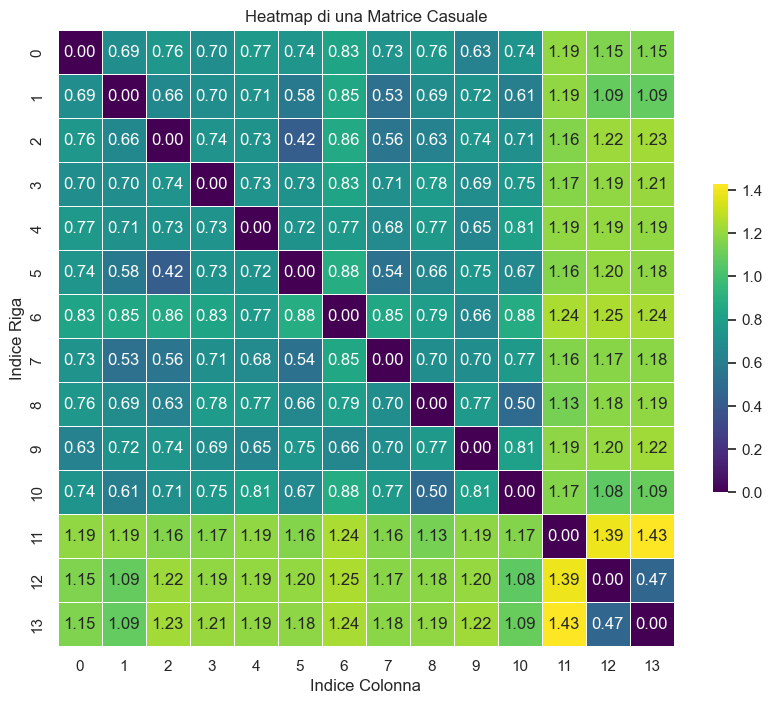

In [111]:
from sentence_transformers import SentenceTransformer, util

embedding_model_2 = SentenceTransformer("all-mpnet-base-v2", device="cpu")

domande_macronutrienti =[
    "Qual è il valore attuale del Bitcoin?",
    "Quanto viene valutato il Bitcoin in questo momento?",
    "A quanto ammonta il prezzo corrente del Bitcoin?",
    "Qual è la quotazione odierna del Bitcoin?",
    "A quanto si aggira il costo del Bitcoin oggi?",
    "Quanto è il prezzo del Bitcoin al momento?",
    "Qual è l'attuale tariffa del Bitcoin sul mercato?",
    "Come è valutato il Bitcoin in termini di prezzo adesso?",
    "Quanto costa un Bitcoin in questo preciso istante?",
    "Qual è il valore di mercato del Bitcoin oggi?",
    "Quanto vale un Bitcoin in questo momento?",
    "drogarsi fa bene",
    "Which is the current value of Bitcoin?",
    "At this moment, how much is Bitcoin valued at?",
]

emb_test=embedding_model_2.encode(domande_macronutrienti,batch_size=128,device="cpu", convert_to_tensor=True)
import torch
cosine_matrix=[]
l2_matrix=[]
l1_matrix=[]
for a in emb_test:
    tmp_cosine_vector=[]
    tmp_l2_vector=[]    
    tmp_l1_vector=[]
    for b in emb_test:        
        tmp_cosine_vector.append(torch.nn.functional.cosine_similarity(a.unsqueeze(0),b.unsqueeze(0)).item())    
        tmp_l2_vector.append((a-b).norm().item())
        tmp_l1_vector.append(torch.sum(torch.abs(a - b)))
    cosine_matrix.append(tmp_cosine_vector)
    l2_matrix.append(tmp_l2_vector)
    l1_matrix.append(tmp_l1_vector)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn rende il plot ancora più attraente

matrice = l2_matrix  # Una matrice 10x10

# Utilizza seaborn per un heatmap attraente
sns.set_theme()  # Imposta lo stile di default di seaborn, che abbellisce i plot matplotlib
plt.figure(figsize=(10, 8))  # Imposta le dimensioni del plot

# Crea un heatmap dalla matrice
sns.heatmap(matrice, annot=True, fmt=".2f", cmap='viridis', square=True,
            linewidths=.5, cbar_kws={"shrink": .5})

# Titoli e etichette (opzionale)
plt.title('Heatmap di una Matrice')
plt.xlabel('Indice Colonna')
plt.ylabel('Indice Riga')

# Mostra il plot
plt.show()



### Back in the game, we are gonna go back to the RAG

Let's recap the RAG briefly.

RAG stands for Retrieval Augmented Generation.

Which is another way to say: "Given a query, search for relevant context and answer based on those resources"

1. **Retrieval**: Get relevant resources given a query. Those resources are the main qualty factor for the RAG

2. **Augmentation**: LLMs are capable of generating text given a prompt. However, they are prone to hallucination, which means generating text that *looks* right, but has no relevant infos or even worse it has wrong informations.

3. **Generation**: When you retrieve relevant infos using embeddings models and/or vector database, you can use them to augment/flavour the answers, giving you more accurate answers and the ability to investigate more


The whole idea of RAG is to get an LLM to be more factually correct based on your own input as well as have a reference to where the generated output may have come from.


### Similarity search

Similarity search or semantic search or vector search is the idea of searching on *vibe*.

Which means that you search based on *semantic*.

Example:

Let's say you have a text about finance, and you wanna search about a specific topic, you can go either with control f or you can do semantic search.

1. Control-F (or similar), you may get accurate result, but you may not find phrases or go in depth with the search

2. Semantic Search, you get text that has the *vibe* or the *semantic similary* of the question you are giving




In [51]:
import random

import torch
import numpy as np
import pandas as pd

def convert_to_tensor(test:str)->torch.tensor:
    test_2=test.replace("tensor([","").replace("])","").replace("\n","").replace(" ","").split(",")

    for i in range(len(test_2)):
        test_2[i]=float(test_2[i])

    return torch.tensor(test_2)

device="cpu"


###This block of code is to get the embeddings from the csv file since is much faster than re-embedding the text, but the embeddings are saved as strings, so we need to convert them to tensors


text_chunks_and_embeddings_df=pd.read_csv("text_chunks_and_embeddings_df.csv",sep=";")

text_chunks_and_embeddings_df["embedding"]=text_chunks_and_embeddings_df["embedding"]

text_chunks_and_embeddings_df["embedding"]=text_chunks_and_embeddings_df["embedding"].apply(convert_to_tensor)

text_chunks_and_embeddings_df["embedding"]=text_chunks_and_embeddings_df["embedding"].apply(lambda x: x.to(device))

embeddings = torch.tensor(np.array(text_chunks_and_embeddings_df["embedding"].tolist()), dtype=torch.float32).to(device)

embeddings.shape

torch.Size([1790, 768])

In [52]:
embeddings[0]



    

tensor([ 6.7424e-02,  9.0228e-02, -5.0955e-03, -3.1755e-02,  7.3908e-02,
         3.5198e-02, -1.9799e-02,  4.6769e-02,  5.3573e-02,  5.0123e-03,
         3.3393e-02, -1.6222e-03,  1.7608e-02,  3.6265e-02, -3.1677e-04,
        -1.0712e-02,  1.5426e-02,  2.6218e-02,  2.7766e-03,  3.6494e-02,
        -4.4411e-02,  1.8936e-02,  4.9012e-02,  1.6402e-02, -4.8578e-02,
         3.1829e-03,  2.7299e-02, -2.0475e-03, -1.2283e-02, -7.2805e-02,
         1.2045e-02,  1.0730e-02,  2.1000e-03, -8.1777e-02,  2.6783e-06,
        -1.8143e-02, -1.2080e-02,  2.4717e-02, -6.2747e-02,  7.3544e-02,
         2.2163e-02, -3.2877e-02, -1.8010e-02,  2.2295e-02,  5.6137e-02,
         1.7951e-03,  5.2593e-02, -3.3174e-03, -8.3388e-03, -1.0629e-02,
         2.3192e-03, -2.2393e-02, -1.5301e-02, -9.9306e-03,  4.6532e-02,
         3.5747e-02, -2.5476e-02,  2.6369e-02,  3.7492e-03, -3.8268e-02,
         2.5833e-02,  4.1287e-02,  2.5818e-02,  3.3297e-02, -2.5178e-02,
         4.5152e-02,  4.4898e-04, -9.9662e-02,  4.9

In [53]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device=device) # choose the device to load the model to

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\cpiccinin\OneDrive - Deloitte (O365D)\Desktop\RAG 2.0\.venv\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\cpiccinin\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [60]:
#1. Define the query

query="macronutrient functions"

print(f"Query: {query}")

query_embedding = embedding_model.encode(query, convert_to_tensor=True)

from time import perf_counter as timer

start_time = timer()

dot_scores=util.dot_score(a=query_embedding, b=embeddings)[0]

end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

top_results_dot_product = torch.topk(dot_scores, k=5)

top_results_dot_product

Query: macronutrient functions
Time take to get scores on 1790 embeddings: 0.00098 seconds.


torch.return_types.topk(
values=tensor([0.6843, 0.6717, 0.6517, 0.6493, 0.6478]),
indices=tensor([43, 48, 47, 52, 42]))

In [61]:
import textwrap

def print_wrapped(text,wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)
    
print(f"Query: {query}")
print("Results:")

for score,idx in zip(top_results_dot_product[0],top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")
    

    

Query: macronutrient functions
Results:
Score: 0.6843
Macronutrients Nutrients that are needed in large amounts are called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically processed into cellular energy.
The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of
food energy is the calorie. On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand. A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
are molecules 

### Let's get the k best result of a semantic search

We are gonna build a function that retrieves the best resource using two possibile distances

In [62]:
def retrieve_relevant_resources(
                                query:str,
                                embeddings:torch.tensor,
                                pages_and_chunks:list[dict],
                                print_time=False,
                                print_results=True,
                                top_k:int=5,
                                distance="cosine"
                                ):
    
    """Retrieve the top k relevant resources given a query
    Args:
    query: str: The query to search for
    embeddings: torch.tensor: The embeddings of the text chunks
    pages_and_chunks: list[dict]: The text chunks and their embeddings
    top_k: int: The number of top results to return
    print_time: bool: Whether to print the time taken to get the results
    print_results: bool: Whether to print the results
    distance: str: The distance metric to use. Either "cosine" or "dot"
    Returns:
    top_results_dot_product: torch.tensor: The top k results
    """
    query_embedding = embedding_model.encode(query, convert_to_tensor=True)
    
    start_time = timer()
    
    if distance=="cosine":    
        dot_scores=util.cos_sim(a=query_embedding, b=embeddings)[0]

    elif distance=="dot":
        dot_scores=util.dot_score(a=query_embedding, b=embeddings)[0]
        
    top_results_dot_product = torch.topk(dot_scores, k=top_k)
    
    end_time = timer()
    if print_time:
        print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")
    
    scores,indices=torch.topk(dot_scores, k=top_k)
    
    if print_results:
        print(f"Query: {query}\n")
        print("Results:")
        # Loop through zipped together scores and indicies
        for score, index in zip(scores, indices):
            print(f"Score: {score:.4f}")
            # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
            print_wrapped(pages_and_chunks[index]["sentence_chunk"])
            # Print the page number too so we can reference the textbook further and check the results
            print(f"Page number: {pages_and_chunks[index]['page_number']}")
            print("\n")
    
    return scores,indices

       


In [73]:
query = "macronutrients"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings,
                                              pages_and_chunks=pages_and_chunks,
                                              distance="dot",
                                              print_time=True,
                                              print_results=False
                                              )




Time take to get scores on 1790 embeddings: 0.00071 seconds.


In [102]:
import os 
import io
import dotenv
from Rag.decorators import *
from langchain_openai import AzureChatOpenAI
from dotenv import load_dotenv
load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
OPENAI_DEPLOYMENT_NAME=os.getenv('OPENAI_DEPLOYMENT_NAME')
OPENAI_MODEL_NAME=os.getenv('OPENAI_MODEL_NAME')
OPENAI_EMBEDDING_DEPLOYMENT_NAME = os.getenv('OPENAI_EMBEDDING_DEPLOYMENT_NAME')
OPENAI_EMBEDDING_MODEL_NAME = os.getenv('OPENAI_EMBEDDING_MODEL_NAME')
OPENAI_API_VERSION = os.getenv('OPENAI_API_VERSION')
OPENAI_API_TYPE = os.getenv('OPENAI_API_TYPE')

llm = AzureChatOpenAI(azure_endpoint="https://dttopenaifrance.openai.azure.com/",
                          openai_api_key=OPENAI_API_KEY, 
                          deployment_name=OPENAI_DEPLOYMENT_NAME, 
                          model_name=OPENAI_MODEL_NAME, 
                          openai_api_version=OPENAI_API_VERSION,
                          temperature=0.5,
                          max_tokens=1500)

In [108]:
query="What is the pourpose of macronutrients?"


@retry()
def create_similar_queries(query:str)->list:
    try:
        
        sim_queries=llm.invoke(f"Given the query '{query}', please provide 5 ways to say the same query in other words. using a python list,just the python list, no explanation").content.replace("[","").replace("]","").replace("'","").split(",")
    except Exception as e:
        raise Exception(f"An error occurred while trying to generate similar queries: {e}")
        sim_queries=[]
    return sim_queries + [query]


queries=create_similar_queries(query)


Running (1): create_similar_queries()


In [126]:
scores=[]
indices=[]
sentences=[]


for i in queries:
    for k in ["dot","cosine"]:
    
        tmp_scores, tmp_indices = retrieve_relevant_resources(query=i,
                                                embeddings=embeddings,
                                                pages_and_chunks=pages_and_chunks,
                                                distance=k,
                                                print_time=False,
                                                print_results=False,
                                                top_k=10
                                                )
        
        scores+=tmp_scores.tolist()
        indices+=tmp_indices.tolist()
        for j in tmp_indices:
            sentences.append(pages_and_chunks[j]["sentence_chunk"])
        
    
    
scores=list(set(scores))
indices=list(set(indices))
sentences=list(set(sentences))
sentences

['details on food composition data, go to the USDA Food Composition Databases page. An Organism Requires Energy and Nutrient Input Energy is required in order to build molecules into larger macromolecules (like proteins), and to turn macromolecules into organelles and cells, which then turn into tissues, organs, and organ systems, and finally into an organism. Proper nutrition provides the necessary nutrients to make the energy that supports life’s processes. Your body builds new macromolecules from the nutrients in food. Nutrient and Energy Flow Energy is stored in a nutrient’s chemical bonds. Energy comes from sunlight, which plants capture and, via photosynthesis, use it to transform carbon dioxide in the air into the molecule glucose. When the glucose bonds are broken, energy is released. Bacteria, plants, and animals (including humans) harvest the energy in glucose via a biological process called cellular respiration. In this process oxygen is required and the chemical energy of g

In [143]:
query="What is the pourpose of macronutrients?"

def create_prompt(query:str,sentences:list)->str:
    
    pre_prompt=llm.invoke(f"""Given this question, {query} build a useful prompt for an AI model to answer the question.""").content

    prompt = f"""
    Given this query '{pre_prompt}'and this context: {"".join(sentences)}, please provide a summary of the most relevant information.
    Respond in the same language as the query.
    Do not include the query in the response.
    If the context does not include useful informations to give an answer respond 'I don't have enough information to respond'.
    DO NOT make things up, if you can't respond say 'I cannot respond'.
    """
    return prompt




In [148]:
response=llm.invoke(create_prompt(query,sentences)).content



['M',
 'a',
 'c',
 'r',
 'o',
 'n',
 'u',
 't',
 'r',
 'i',
 'e',
 'n',
 't',
 's',
 ' ',
 'a',
 'r',
 'e',
 ' ',
 'e',
 's',
 's',
 'e',
 'n',
 't',
 'i',
 'a',
 'l',
 ' ',
 'n',
 'u',
 't',
 'r',
 'i',
 'e',
 'n',
 't',
 's',
 ' ',
 't',
 'h',
 'a',
 't',
 ' ',
 'a',
 'r',
 'e',
 ' ',
 'n',
 'e',
 'e',
 'd',
 'e',
 'd',
 ' ',
 'i',
 'n',
 ' ',
 'l',
 'a',
 'r',
 'g',
 'e',
 ' ',
 'a',
 'm',
 'o',
 'u',
 'n',
 't',
 's',
 ' ',
 'i',
 'n',
 ' ',
 't',
 'h',
 'e',
 ' ',
 'h',
 'u',
 'm',
 'a',
 'n',
 ' ',
 'd',
 'i',
 'e',
 't',
 '.',
 ' ',
 'T',
 'h',
 'e',
 'y',
 ' ',
 'p',
 'r',
 'o',
 'v',
 'i',
 'd',
 'e',
 ' ',
 't',
 'h',
 'e',
 ' ',
 'b',
 'o',
 'd',
 'y',
 ' ',
 'w',
 'i',
 't',
 'h',
 ' ',
 'e',
 'n',
 'e',
 'r',
 'g',
 'y',
 ' ',
 'a',
 'n',
 'd',
 ' ',
 'a',
 'r',
 'e',
 ' ',
 'n',
 'e',
 'c',
 'e',
 's',
 's',
 'a',
 'r',
 'y',
 ' ',
 'f',
 'o',
 'r',
 ' ',
 'v',
 'a',
 'r',
 'i',
 'o',
 'u',
 's',
 ' ',
 'b',
 'o',
 'd',
 'i',
 'l',
 'y',
 ' ',
 'f',
 'u',
 'n',
 'c',
 't'

['details on food composition data, go to the USDA Food Composition Databases page. An Organism Requires Energy and Nutrient Input Energy is required in order to build molecules into larger macromolecules (like proteins), and to turn macromolecules into organelles and cells, which then turn into tissues, organs, and organ systems, and finally into an organism. Proper nutrition provides the necessary nutrients to make the energy that supports life’s processes. Your body builds new macromolecules from the nutrients in food. Nutrient and Energy Flow Energy is stored in a nutrient’s chemical bonds. Energy comes from sunlight, which plants capture and, via photosynthesis, use it to transform carbon dioxide in the air into the molecule glucose. When the glucose bonds are broken, energy is released. Bacteria, plants, and animals (including humans) harvest the energy in glucose via a biological process called cellular respiration. In this process oxygen is required and the chemical energy of g

c:\Users\cpiccinin\OneDrive - Deloitte (O365D)\Desktop\RAG 2.0\.venv\Lib\site-packages\whisper\transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


FileNotFoundError: [WinError 2] The system cannot find the file specified

['tiny.en',
 'tiny',
 'base.en',
 'base',
 'small.en',
 'small',
 'medium.en',
 'medium',
 'large-v1',
 'large-v2',
 'large-v3',
 'large']